In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

[*********************100%%**********************]  1 of 1 completed


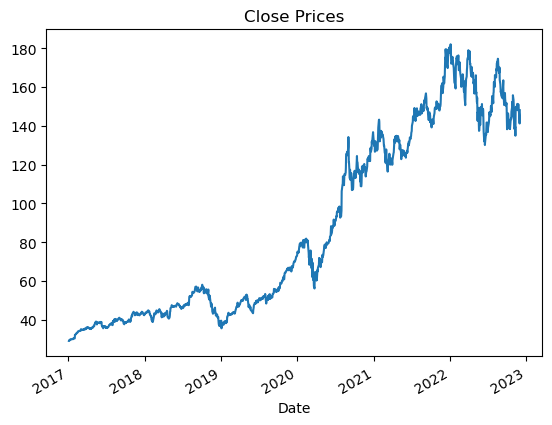

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.33it/s]
/home/balram/Downloads/#/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Open__mean_abs_change' 'Open__mean_change'
 'Open__mean_second_derivative_central' ...
 'Volume__permutation_entropy__dimension_7__tau_1'
 'Volume__query_similarity_count__query_None__threshold_0.0'
 'Volume__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(
/home/balram/Downloads/#/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['Open__mean_abs_change' 'Open__mean_change'
 'Open__mean_second_derivative_central' ...
 'Volume__permutation_entropy__dimension_7__tau_1'
 'Volume__query_similarity_count__query_None__threshold_0.0'
 'Volume__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           44400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 127351 (497.46 KB)
Trainable params: 127351 (497.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
1131/1131 - 12s - loss: 0.0016 - 12s/epoch - 11ms/step
Epoch 2/3
1131/1131 - 11s - loss: 6.5435e-04 - 11s/epoch - 9ms/step
Epoch 3/3
113

/tmp/ipykernel_11775/3916742965.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


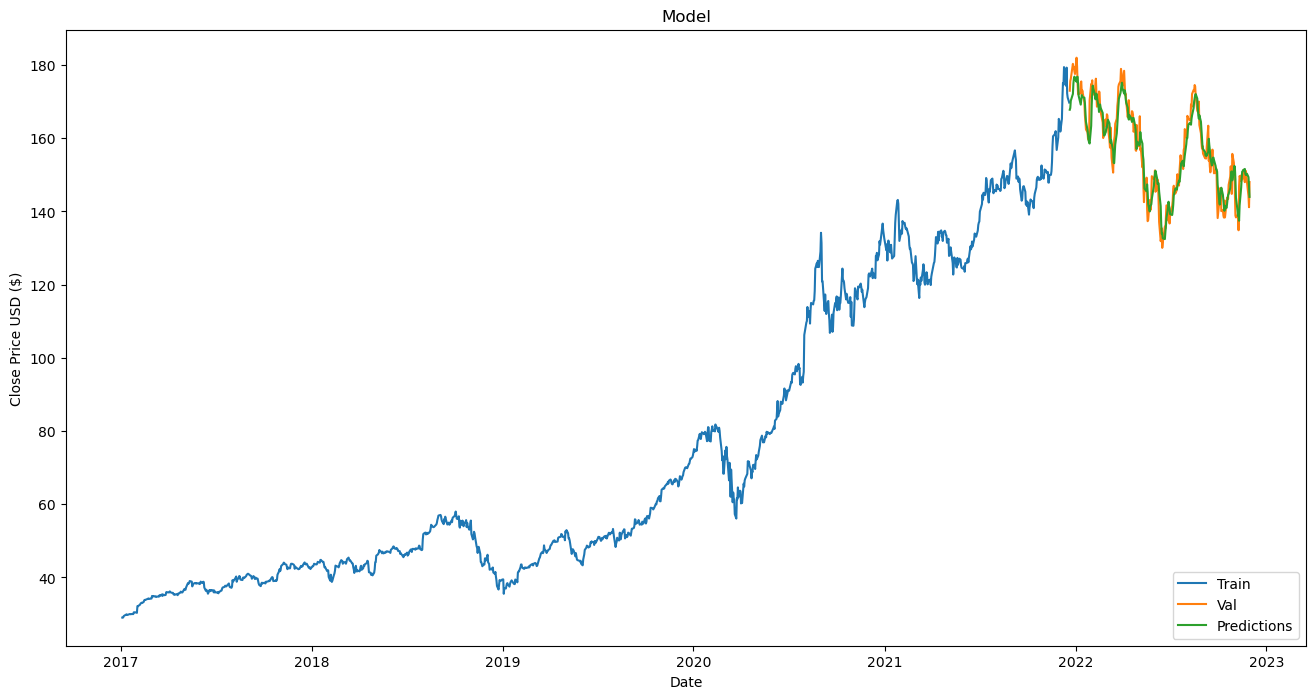

Root Mean Squared Error (RMSE): 3.963430892311197


In [7]:
class StockAnalysis:
    def __init__(self, stock_symbol, start_date, end_date):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date

    def download_stock_data(self):
        """Download stock data using yFinance."""
        stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
        return stock_data

    def plot_stock_prices(self, stock_data, column='Close'):
        """Plot stock prices."""
        stock_data[column].plot(title=f'{column} Prices')
        plt.show()

    def prepare_data(self, stock_data, target_column='Close', n_steps=60):
        """Prepare data for time series prediction."""
        numerical_columns = stock_data

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(numerical_columns)

        scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns.columns)
        scaled_df['Date'] = pd.Series(stock_data.index)

        train_size = int(len(stock_data) * 0.8)
        train_data = scaled_df.iloc[:train_size]
        test_data = scaled_df.iloc[train_size:]

        X_train_features, X_test_features, y_train, y_test = self.extract_and_prepare_features(
            train_data, test_data, target_column)

        X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = self.reshape_for_lstm(
            X_train_features, X_test_features, y_train, y_test, n_steps)

        return X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm

    def extract_and_prepare_features(self, train_data, test_data, target_column):
        """Extract and prepare features using tsfresh."""
        X_train_features = extract_features(train_data, column_id='Date', column_sort='Date')
        X_test_features = extract_features(test_data, column_id='Date', column_sort='Date')

        X_train_features = impute(X_train_features)
        X_test_features = impute(X_test_features)

        common_features = list(set(X_train_features.columns).intersection(X_test_features.columns))
        X_train_features = X_train_features[common_features]
        X_test_features = X_test_features[common_features]

        X_train_features.index = train_data.index
        X_test_features.index = test_data.index

        y_train = train_data[target_column][X_train_features.index]
        y_test = test_data[target_column][X_test_features.index]

        # Here I am selecting the top 10 extracted features
        k_best_selector = SelectKBest(score_func=f_regression, k=10)
        X_train_selected = k_best_selector.fit_transform(X_train_features, y_train)
        X_test_selected = k_best_selector.transform(X_test_features)

        return X_train_selected, X_test_selected, y_train, y_test

    def reshape_for_lstm(self, X_train_selected, X_test_selected, y_train, y_test, n_steps):
        """Reshape data for LSTM input."""
        X_train_lstm, X_test_lstm = [], []
        y_train_lstm, y_test_lstm = [], []

        for i in range(len(X_train_selected) - n_steps):
            X_train_lstm.append(X_train_selected[i:i + n_steps])
            y_train_lstm.append(y_train.iloc[i + n_steps])

        for i in range(len(X_test_selected) - n_steps):
            X_test_lstm.append(X_test_selected[i:i + n_steps])
            y_test_lstm.append(y_test.iloc[i + n_steps])

        return (
            np.array(X_train_lstm), np.array(X_test_lstm),
            np.array(y_train_lstm), np.array(y_test_lstm)
        )

    def build_lstm_model(self, input_shape):
        """Build an LSTM model."""
        model = keras.Sequential()
        model.add(layers.LSTM(100, return_sequences=True, input_shape=input_shape))
        model.add(layers.LSTM(100, return_sequences=False))
        model.add(layers.Dense(25))
        model.add(layers.Dense(1))
        model.summary()
        return model

    def evaluate_model(self, model, x_test, y_test, stock_data):
        """Evaluate the LSTM model."""
        #predictions = model.predict(x_test.reshape(x_test.shape[0], -1))
        predictions = model.predict(x_test)

        # Reshape the scaler to match the shape of the predictions
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(stock_data['Close'].values.reshape(-1, 1))

        # Inverse transform the predictions to the original scale
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

        predictions_list = predictions.tolist()
        Actual = y_test.tolist()

        # Create a DataFrame
        df = pd.DataFrame({'Predictions': predictions_list, 'Actual': Actual})
        print(df)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        return rmse,predictions
    
    def plot_training_validation_predictions(self, stock_data, x_test, predictions):
        print("predictionsshape",predictions.shape)
        data = stock_data.filter(['Close'])
        training_data_len = len(stock_data) - len(x_test)
        train = data[:training_data_len]
        validation = data[training_data_len:]
        validation['Predictions'] = predictions

        plt.figure(figsize=(16, 8))
        plt.title('Model')
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.plot(train)
        plt.plot(validation[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

    

    def analyze_stock(self):
        """Analyze stock data."""
        # Download stock data
        stock_data = self.download_stock_data()

        # Plot stock prices
        self.plot_stock_prices(stock_data)

        # Prepare data for time series prediction
        X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = self.prepare_data(
            stock_data, target_column='Close', n_steps=60)

        # Build the LSTM model
        input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
        model = self.build_lstm_model(input_shape)

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the model to your training data
        model.fit(X_train_lstm, y_train_lstm, batch_size=1, epochs=3, verbose=2)

        # Evaluate the model
        rmse,predictions = self.evaluate_model(model, X_test_lstm, y_test_lstm, stock_data)
        
        self.plot_training_validation_predictions(stock_data,X_test_lstm,predictions)

        return rmse

if __name__ == "__main__":
    stock_symbol = 'AAPL'
    start_date = '2017-01-01'
    end_date = '2022-12-01'
    stock_analyzer = StockAnalysis(stock_symbol, start_date, end_date)

    rmse = stock_analyzer.analyze_stock()
    print(f"Root Mean Squared Error (RMSE): {rmse}")
